<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-08-26 05:11:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-08-26 05:11:36 (12.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

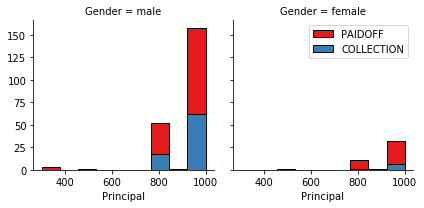

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

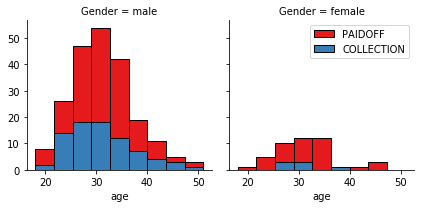

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

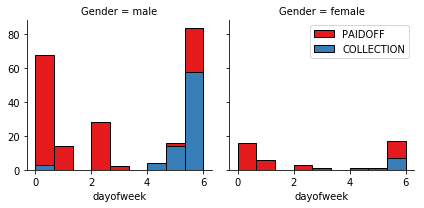

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
#Define a scaler as necessary for training data, which can be later used for test data
scaler_X = preprocessing.StandardScaler().fit(X)
X= scaler_X.transform(X)
X.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


(346, 8)

In [20]:
X = pd.DataFrame(X)
y = pd.Series(y)

#Lets rename columns to get rid of spaces within them
X.columns = ['Principal', 'Terms', 'Age', 'Gender', 'Weekend', 'Bachelor',
       'HS_Below', 'College']
y = y.replace({'PAIDOFF':1, 'COLLECTION':0})

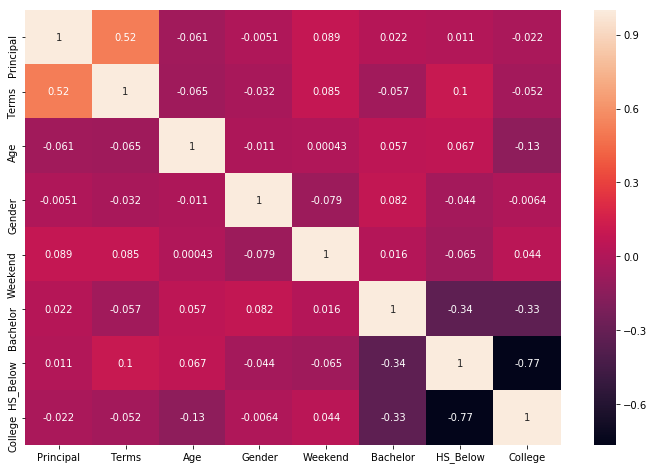

In [21]:
#Lets check for any correlation in factors
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), annot=True)

#Our parameters do not suffer from excess correlation, we can conclude that they are fairly independant of each other and move ahead.

# Define a Pipe for Precprocessing steps, which can be inherited to unseen data later

In [22]:
def my_pipe(df):
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    Feature = df[['Principal','terms','age','Gender','weekend']]
    Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
    Feature.drop(['Master or Above'], axis = 1,inplace=True)
    X= scaler_X.transform(Feature)

    X = pd.DataFrame(X)
    X.columns = ['Principal', 'Terms', 'Age', 'Gender', 'Weekend', 'Bachelor',
           'HS_Below', 'College']

    y = df['loan_status'].values
    y = pd.Series(y)
    y = y.replace({'PAIDOFF':1, 'COLLECTION':0})
    
    return X.copy(), y.copy()

In [23]:
from sklearn.metrics import accuracy_score,r2_score,classification_report, roc_auc_score
#Suppress Warninings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score,r2_score,classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
#Machine Learning Algorithm (MLA) Selection and Initialization
from sklearn import metrics
from sklearn import svm
from sklearn import linear_model, tree, neighbors
from sklearn import model_selection
from xgboost import XGBClassifier

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [24]:
KNN = 'KNN_Classifier'
DECISION_TREE = 'DecisionTree_Classifier'
SVM_ = 'SVM_Classifier'
LOGISTIC = 'Logistic Regression Classifier'

JACCARD = 'JACCARD'
F1_SCORE = 'F1 Score'
LOG_LOSS = 'Log Loss'

clf_knn = neighbors.KNeighborsClassifier() #Nearest Neighbor


#Define the three scoring metricc : Jaccard, F1 score and Log Loss
scorers = {JACCARD:metrics.make_scorer(metrics.jaccard_similarity_score), F1_SCORE: metrics.make_scorer(metrics.f1_score), LOG_LOSS: metrics.make_scorer(metrics.log_loss)}

#Create a results dataframe to save metric results on Test data
resuls_df = pd.DataFrame(columns= scorers.keys())

#Prepare cross-validation test (5 fold) with different scoring : 80% train, 20% test
for scorer in scorers:
    cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 )
    cv_results = model_selection.cross_validate(clf_knn, X, y, cv  = cv_split, 
                                                return_train_score=True, scoring=scorers[scorer])

    #Cross validation result
    resuls_df.loc[KNN, scorer] = cv_results['test_score'].mean()

    #Fit the model
    clf_knn.fit(X, y)

    
resuls_df

,JACCARD,F1 Score,Log Loss
KNN_Classifier,0.737143,0.831564,9.07889


# Decision Tree

In [25]:
clf_tree = tree.DecisionTreeClassifier() #Decision Tree

for scorer in scorers:
    cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 )
    cv_results = model_selection.cross_validate(clf_tree, X, y, cv  = cv_split, 
                                                return_train_score=True, scoring=scorers[scorer])
    #Cross validation result
    resuls_df.loc[DECISION_TREE, scorer] = cv_results['test_score'].mean()
    
    #Fit the model
    clf_tree.fit(X, y)

resuls_df

,JACCARD,F1 Score,Log Loss
KNN_Classifier,0.737143,0.831564,9.07889
DecisionTree_Classifier,0.665714,0.76516,11.4472


# Support Vector Machine

In [26]:
clf_svm = svm.SVC() #Support Vector Machine Classifier

for scorer in scorers:
    cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 )
    cv_results = model_selection.cross_validate(clf_svm, X, y, cv  = cv_split, 
                                                return_train_score=True, scoring=scorers[scorer])
    #Cross validation result
    resuls_df.loc[SVM_, scorer] = cv_results['test_score'].mean()
    
    #Fit the model
    clf_svm.fit(X, y)

resuls_df

,JACCARD,F1 Score,Log Loss
KNN_Classifier,0.737143,0.831564,9.07889
DecisionTree_Classifier,0.665714,0.76516,11.4472
SVM_Classifier,0.708571,0.822968,10.0658


# Logistic Regression

In [27]:
clf_logistic = linear_model.LogisticRegression() #Logistic Regression Classifier

for scorer in scorers:
    cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 )
    cv_results = model_selection.cross_validate(clf_logistic, X, y, cv  = cv_split, 
                                                return_train_score=True, scoring=scorers[scorer])
    
    #Cross validation result
    resuls_df.loc[LOGISTIC, scorer] = cv_results['test_score'].mean()
    
    #Fit the model
    clf_logistic.fit(X, y)

resuls_df

,JACCARD,F1 Score,Log Loss
KNN_Classifier,0.737143,0.831564,9.07889
DecisionTree_Classifier,0.665714,0.76516,11.4472
SVM_Classifier,0.708571,0.822968,10.0658
Logistic Regression Classifier,0.728571,0.831296,9.37497


# Grid Search for best parameters

In [38]:
#Grid Search
import time

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
            #KNN
            [{
            'n_neighbors': [1,2,3,4,5,6,7,11], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
            #Decision Tree
            [{
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            }],
            
            #SVM
            [{
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
             }],
            
            #Logistic Regression
            [{
            'C': np.logspace(0, 4, 10),
            'penalty': ['l1', 'l2']
            }]
        ]



models = [clf_knn, clf_tree, clf_svm, clf_logistic]

#Iterate over all models and their hyperparameter possibilities to find the most optimum parameters for f1-score metric.
for clf, param in zip(models, grid_param): #https://docs.python.org/3/library/functions.html#zip

    best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'f1')
    best_search.fit(X, y)
    best_param = best_search.best_params_
    
    print('The best parameter for {} is {}.'.format(clf.__class__.__name__, best_param))
    
    #Set the best performing parameters to the respective classifier
    clf.set_params(**best_param) 

The best parameter for KNeighborsClassifier is {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}.
The best parameter for DecisionTreeClassifier is {'criterion': 'gini', 'max_depth': 2}.
The best parameter for SVC is {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}.
The best parameter for LogisticRegression is {'C': 1.0, 'penalty': 'l1'}.


In [39]:
#Check performance scores after hyper-parameter tuning

#Create a results dataframe to save metric results on Test data
models = [clf_knn, clf_tree, clf_svm, clf_logistic]
resuls_df = pd.DataFrame(columns= scorers.keys())

for model, name in zip(models, [KNN,DECISION_TREE, SVM_, LOGISTIC]):
    cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 )
    for scorer in scorers:
        cv_results = model_selection.cross_validate(model, X, y, cv  = cv_split, 
                                                        return_train_score=True, scoring=scorers[scorer])
        resuls_df.loc[name, scorer] = cv_results['test_score'].mean()
resuls_df    

#We have defintely improved over our previous results, we accept the new parameters for the respective models and move on

,JACCARD,F1 Score,Log Loss
KNN,0.748571,0.840768,8.68417
Decision Tree,0.754286,0.859269,8.48687
SVM,0.748571,0.855411,8.68423
LogisticRegression,0.745714,0.846972,8.78289


# Model Evaluation using Test set

In [40]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [41]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-08-26 05:17:02--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-08-26 05:17:02 (499 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [42]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [43]:
X_test, y_test = my_pipe(test_df)

In [44]:
X_test.head()

,Principal,Terms,Age,Gender,Weekend,Bachelor,HS_Below,College
0,0.515785,0.920718,3.160619,2.377782,-1.205778,2.619854,-0.879977,-0.869681
1,-5.890524,-1.961686,0.673339,-0.420560,0.829340,-0.381701,-0.879977,-0.869681
2,0.515785,0.920718,1.999888,2.377782,0.829340,-0.381701,1.136394,-0.869681
3,0.515785,0.920718,-0.819029,-0.420560,0.829340,-0.381701,-0.879977,1.149847
4,-1.314589,-0.959111,-0.321573,-0.420560,0.829340,2.619854,-0.879977,-0.869681


In [45]:
y_test.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [48]:
#Generate report
KNN = 'KNN'
DECISION_TREE = 'Decision Tree'
SVM_ = 'SVM'
LOGISTIC = 'LogisticRegression'

JACCARD = 'Jaccard'
F1_SCORE = 'F1-score'
LOG_LOSS = 'LogLoss'

#Results dataframe
resuls_df = pd.DataFrame(columns= [JACCARD, F1_SCORE, LOG_LOSS])

models = [clf_knn, clf_tree, clf_svm, clf_logistic]
y_true = y_test

for model, name in zip(models, [KNN,DECISION_TREE, SVM_, LOGISTIC]):
    y_predicted = model.predict(X_test)
    resuls_df.loc[name, JACCARD] = jaccard_similarity_score(y_true, y_predicted)
    resuls_df.loc[name, F1_SCORE] = f1_score(y_true, y_predicted)
    resuls_df.loc[name, LOG_LOSS] = log_loss(y_true, y_predicted)

In [49]:
print('REPORT:')
resuls_df

REPORT:


,Jaccard,F1-score,LogLoss
KNN,0.722222,0.831461,9.59428
Decision Tree,0.703704,0.8,10.2338
SVM,0.648148,0.707692,12.1526
LogisticRegression,0.759259,0.860215,8.31508


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>

# Thank you !!